Referência para entender as aplicações de sobrevivência em R:
https://www.openintro.org/go/?id=survival_analysis_in_R&referrer=/stat/surv.php

In [ ]:
# Instalacao de bibliotecas necessarias:
install.packages(c('survminer', 'plyr', 'muhaz'))

In [ ]:
# Bibliotecas para manipulacao de dados:
library(plyr)
library(dplyr)

# Bibliotecas para analise de sobrevivencia:
library(survival)
library(survminer)
library(muhaz) # computa função de risco instantânea

# Dados

Conside aqui as descrições das variáveis que temos no conjunto de dados.

Veja que são muitas variáveis, então, de acordo com uma análise de sobrevivência, obrigatoriamente ficaremos com a duração do projeto (`Duration in Days`) e a indicação de censura (`State`), mas como proposta do trabalho, vamos averiguar a influência do facebook no sucesso de projetos de financiamento coletivo, de modo que, ficaremos também com as variáveis: indicação de conexão com o facebook (`Facebook Connected`), quantidade de compartilhamentos (`Facebook Shares`), quantidade de amigos (`Facebook Friends`) e qual é a moeda em que o financiamento foi proposto (`Currency`), pois acreditamos que seja uma variável que separa os projetos por regiões.

In [ ]:
# Carregamento dos Dados:
Path <- 'https://raw.githubusercontent.com/derSchmetterling'
Path <- paste0(Path, '/analise_sobrevivencia/main/Dados/18k_Projects.csv')
df <- read.csv2(Path, header=TRUE, sep="	")
glimpse(df)

Rows: 18,142
Columns: 35
$ Id                              <int> 1007121454, 2032015036, 733782855, 514…
$ Name                            <chr> "Nail Art and Photos Printed on your N…
$ Url                             <chr> "https://www.kickstarter.com/projects/…
$ State                           <chr> "failed", "failed", "failed", "failed"…
$ Currency                        <chr> "USD", "USD", "USD", "USD", "USD", "US…
$ Top.Category                    <chr> "Art", "Film & Video", "Fashion", "Pub…
$ Category                        <chr> "Art", "Short Film", "Fashion", "Poetr…
$ Creator                         <chr> "Dodie Egolf", "James Jacobs", "Uchu B…
$ Location                        <chr> "Puyallup", "Boston", "New York", "Det…
$ Updates                         <int> 0, 0, 1, 0, 0, 0, 5, 7, 9, 1, 4, 0, 0,…
$ Comments                        <int> 0, 0, 2, 0, 0, 0, 13, 33, 0, 0, 0, 0, …
$ Rewards                         <int> 9, 8, 17, 4, 12, 13, 21, 9, 30, 9, 4, …
$ Goal         

In [ ]:
# Selecionando apenas as colunas nas quais trabalharemos:
df <- df %>%
      select(duration = Duration.in.Days, censoring = State,
             shares = Facebook.Shares, facebook = Facebook.Connected,
             currency = Currency, friends = Facebook.Friends)
glimpse(df)

Rows: 18,142
Columns: 6
$ duration  <int> 30, 33, 30, 60, 30, 40, 42, 40, 36, 31, 31, 30, 45, 28, 60, …
$ censoring <chr> "failed", "failed", "failed", "failed", "failed", "failed", …
$ shares    <int> 70, 57, 158, 2, 411, 142, 1960, 544, 1202, 110, 6, 185, 0, 2…
$ facebook  <chr> "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", "Yes", "Yes",…
$ currency  <chr> "USD", "USD", "USD", "USD", "USD", "USD", "GBP", "USD", "USD…
$ friends   <int> 272, 573, NA, 1285, 969, 1566, NA, 104, 1284, 319, 537, 1499…


In [ ]:
# tratamento dos dados:

# criando os intervalos para shares:
df$qtd_shares[df$shares >= 800] <- 'Muitos'
df$qtd_shares[df$shares >= 400 & df$shares < 800] <- 'Medios'
df$qtd_shares[df$shares < 400] <- 'Poucos'

# criando os intervalos para friends:
df$qtd_friends[is.na(df$friends)] <- 'Desconhecido'
df$qtd_friends[df$friends >= 400] <- 'Muitos'
df$qtd_friends[df$friends >= 60 & df$friends < 400] <- 'Medios'
df$qtd_friends[df$friends < 60] <- 'Poucos'

glimpse(df)

Rows: 18,142
Columns: 8
$ duration    <int> 30, 33, 30, 60, 30, 40, 42, 40, 36, 31, 31, 30, 45, 28, 60…
$ censoring   <chr> "failed", "failed", "failed", "failed", "failed", "failed"…
$ shares      <int> 70, 57, 158, 2, 411, 142, 1960, 544, 1202, 110, 6, 185, 0,…
$ facebook    <chr> "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", "Yes", "Yes…
$ currency    <chr> "USD", "USD", "USD", "USD", "USD", "USD", "GBP", "USD", "U…
$ friends     <int> 272, 573, NA, 1285, 969, 1566, NA, 104, 1284, 319, 537, 14…
$ qtd_shares  <chr> "Poucos", "Poucos", "Poucos", "Poucos", "Medios", "Poucos"…
$ qtd_friends <chr> "Medios", "Muitos", "Desconhecido", "Muitos", "Muitos", "M…


In [ ]:
# Tratando a censura ou modelando o sucesso:
data <- data.frame(df)

data$censoring[data$censoring == 'failed'] <- 0
data$censoring[data$censoring == 'successful'] <- 1
data$censoring <- as.integer(data$censoring)

glimpse(data)

Rows: 18,142
Columns: 8
$ duration    <int> 30, 33, 30, 60, 30, 40, 42, 40, 36, 31, 31, 30, 45, 28, 60…
$ censoring   <int> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1…
$ shares      <int> 70, 57, 158, 2, 411, 142, 1960, 544, 1202, 110, 6, 185, 0,…
$ facebook    <chr> "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", "Yes", "Yes…
$ currency    <chr> "USD", "USD", "USD", "USD", "USD", "USD", "GBP", "USD", "U…
$ friends     <int> 272, 573, NA, 1285, 969, 1566, NA, 104, 1284, 319, 537, 14…
$ qtd_shares  <chr> "Poucos", "Poucos", "Poucos", "Poucos", "Medios", "Poucos"…
$ qtd_friends <chr> "Medios", "Muitos", "Desconhecido", "Muitos", "Muitos", "M…


# Modelo Geral

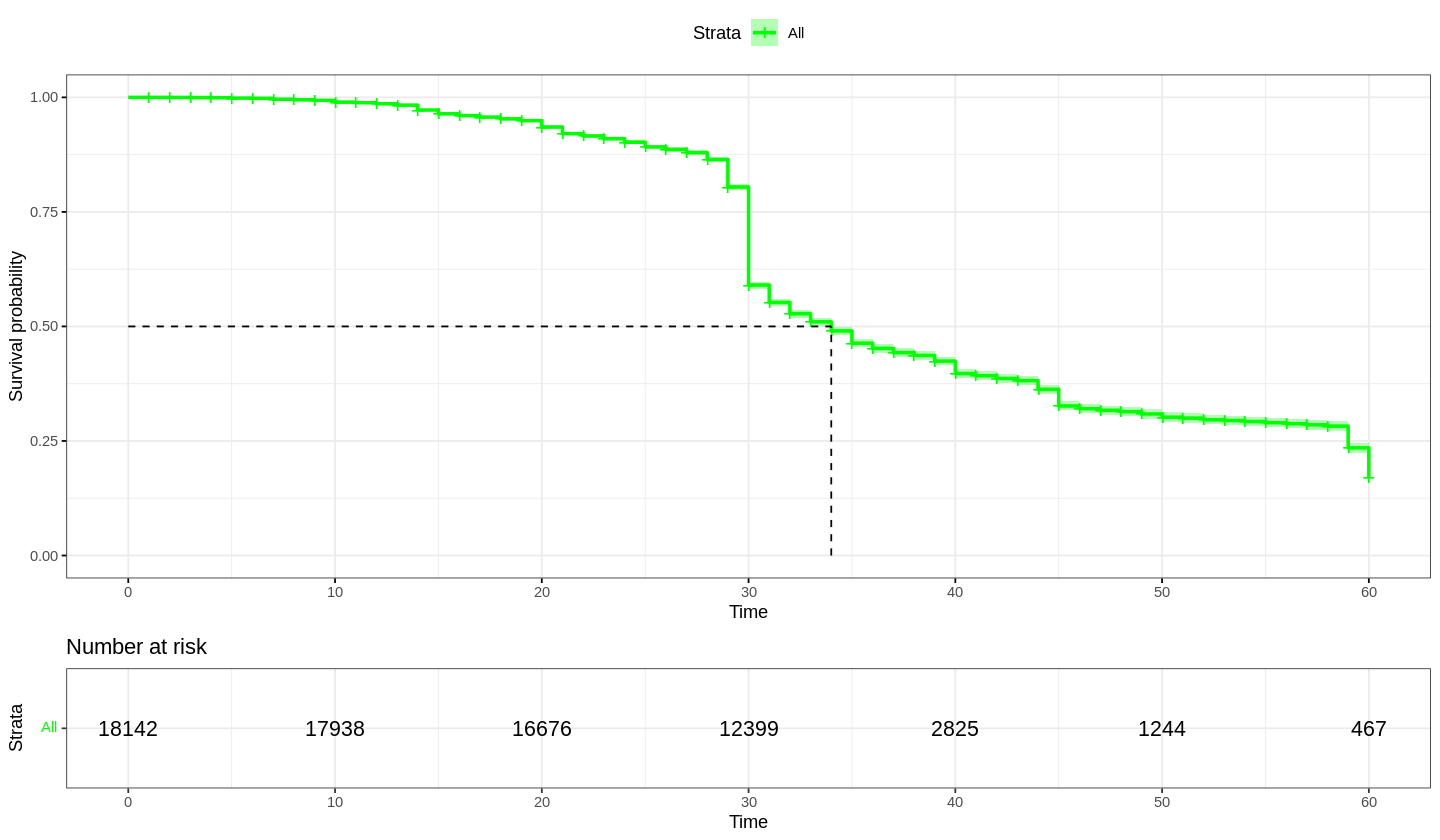

In [ ]:
## Nelson Aalen
eNA <- survfit(coxph(Surv(duration, censoring)~1, data), method = "Breslow")

options(repr.plot.width = 12, repr.plot.height = 9)

ggsurvplot(eNA, data=data, risk.table=T, ggtheme=theme_bw(),
           surv.median.line="hv", palette="green")

In [ ]:
# Kaplan Meier
eKM <- survfit(Surv(duration, censoring) ~ 1, data = data)

eNA_mKM <- list(eNA = eNA, mKM= mKM)
ggsurvplot(eNA_mKM, risk.table = T, ggtheme = theme_bw(),
           conf.int = T, conf.int.style = "step",
           palette = c("green", "orange"), data=data,
           surv.median.line = "hv")

In [ ]:
print('eKM Attributes')
attributes(eKM)

print('eNA Attributes')
attributes(eNA)

In [ ]:
# ggsurvplot(eNA, data=data, risk.table=T, ggtheme=theme_bw(),
#            surv.median.line="hv", palette="green")

plot(eNA$std.chaz)

In [ ]:
# modelo de Kaplan-Meier:
mKM <- survfit(Surv(duration, censoring)~1, data=data)
#summary(mKM) #tabela
print(mKM, print.rmean=TRUE)

Call: survfit(formula = Surv(duration, censoring) ~ 1, data = data)

         n events rmean* se(rmean) median 0.95LCL 0.95UCL
[1,] 18142   9038   39.9     0.138     34      34      34
    * restricted mean with upper limit =  60 


In [ ]:
options(repr.plot.width = 12, repr.plot.height = 7)

plot(mKM$time, -log(mKM$surv),
     xlab='t', ylab='H(t)', col='green', type='l',
     lwd=2, main='Função de Risco Acumulado')

png 
  2

# Modelo para Facebook

In [ ]:
mKM_face <- survfit(Surv(duration, censoring)~facebook, data)
print(mKM_face, print.rmean=TRUE)

Call: survfit(formula = Surv(duration, censoring) ~ facebook, data = data)

                 n events rmean* se(rmean) median 0.95LCL 0.95UCL
facebook=No   5852   2837   40.3     0.245     35      34      35
facebook=Yes 12290   6201   39.7     0.167     34      33      34
    * restricted mean with upper limit =  60 


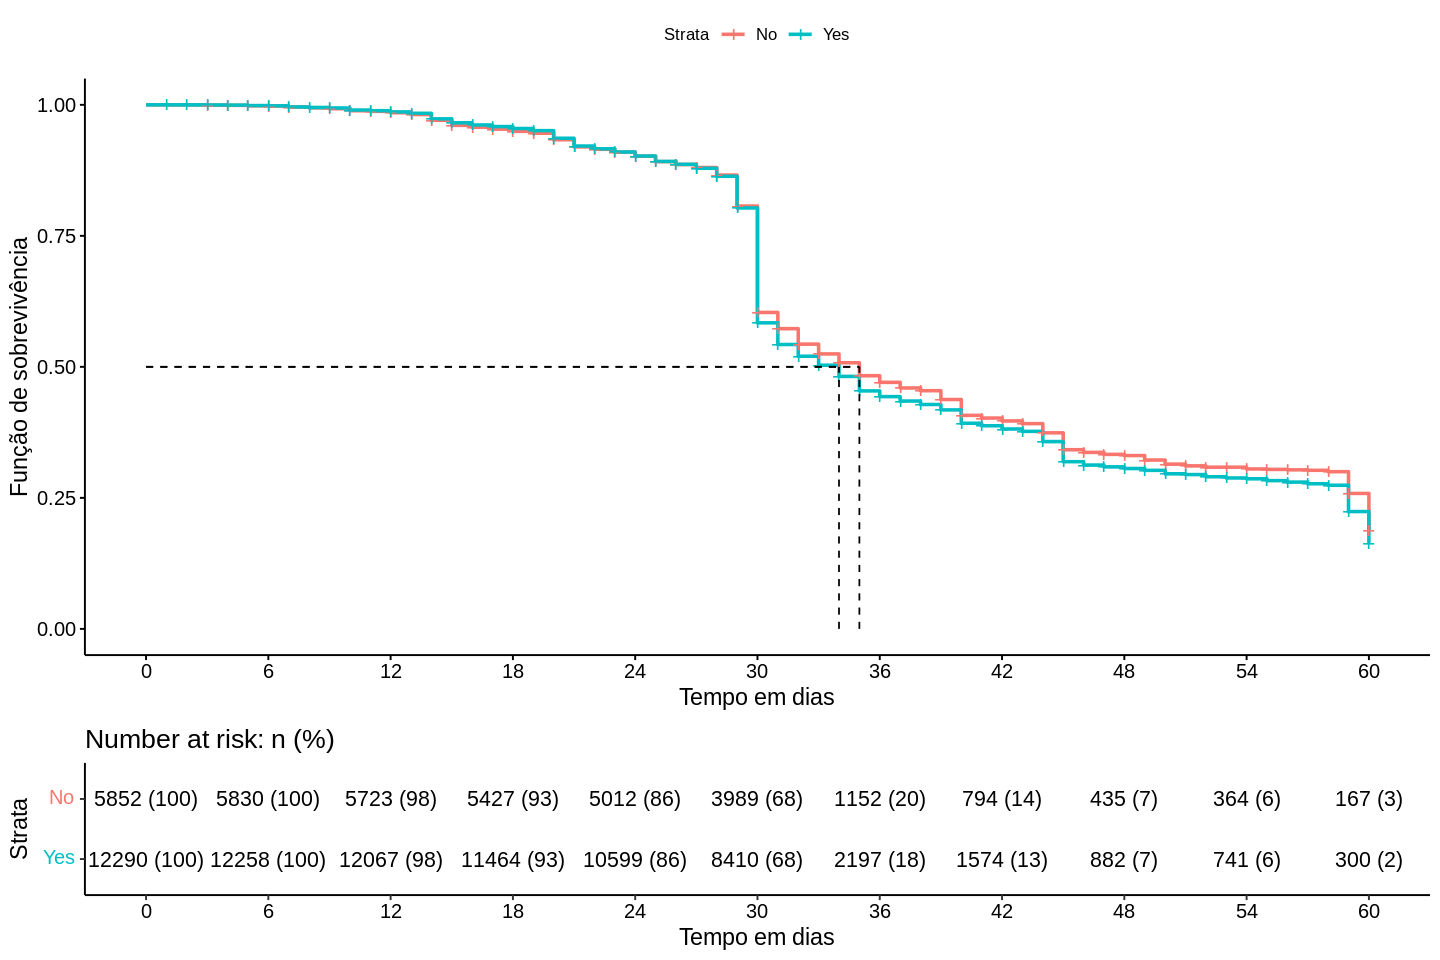

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 8)

ggsurvplot(mKM_face,  # objeto do survfit
           data = data,
           #pval = TRUE, # mostra o p-value do teste log-rank.
           xlab = "Tempo em dias",
           ylab="Função de sobrevivência",
           break.time.by = 6, #eixo X em intervalos de comprimento 6.
           risk.table = "abs_pct", # indivíduos em risco.
           surv.median.line = "hv", # sobrevivência mediana.
           legend.labs = levels(as.factor(data$facebook))
)

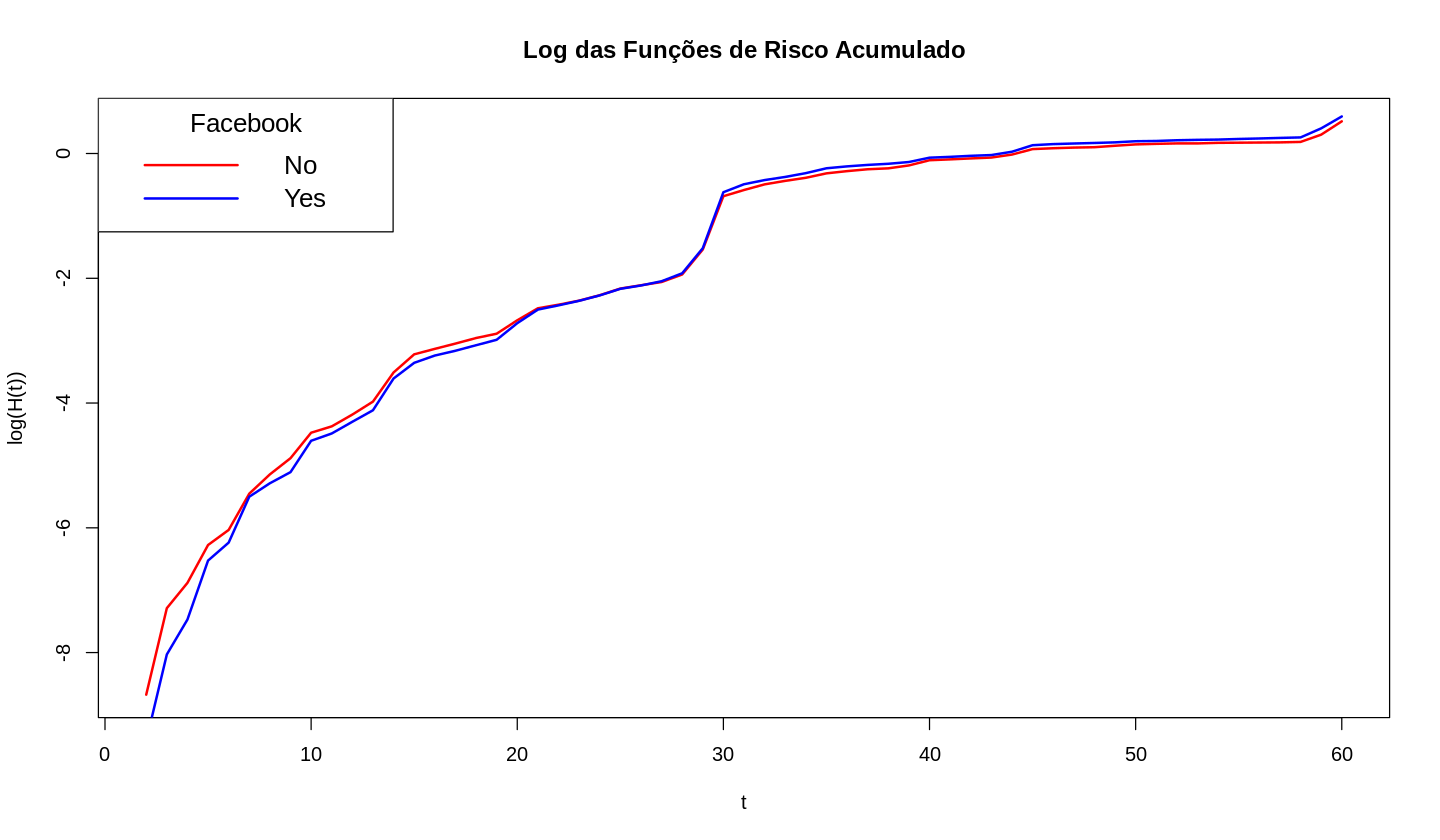

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 7)

plot(mKM_face[1]$time, log(-log(mKM_face[1]$surv)),
     main='Log das Funções de Risco Acumulado', type='l',
     xlab='t', ylab='log(H(t))', col='red', lwd=2
     )
lines(mKM_face[2]$time, log(-log(mKM_face[2]$surv)),
      col='blue', lwd=2)

legend('topleft', legend=c('No', 'Yes'), title='Facebook',
       cex=1.3, lwd=2, col=c('red', 'blue'))

In [ ]:
# Tete logrank valorizando as observações iniciais:
survdiff(Surv(duration, censoring)~facebook, data, rho=3)

Call:
survdiff(formula = Surv(duration, censoring) ~ facebook, data = data, 
    rho = 3)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
facebook=No   5852     1430     1470     1.079      2.69
facebook=Yes 12290     3130     3090     0.513      2.69

 Chisq= 2.7  on 1 degrees of freedom, p= 0.1 

# Modelos para Shares

## Comparação direta entre os intervalos

In [ ]:
# Modelo de Kaplan-Meier separado por Covariavel:
mKM_shares <- survfit(Surv(duration, censoring)~qtd_shares, data=data)
print(mKM_shares, print.rmean=TRUE)

Call: survfit(formula = Surv(duration, censoring) ~ qtd_shares, data = data)

                      n events rmean* se(rmean) median 0.95LCL 0.95UCL
qtd_shares=Medios  2018   1587   34.0     0.271     30      30      30
qtd_shares=Muitos  1680   1426   34.1     0.255     30      30      30
qtd_shares=Poucos 14444   6025   42.2     0.168     40      39      40
    * restricted mean with upper limit =  60 


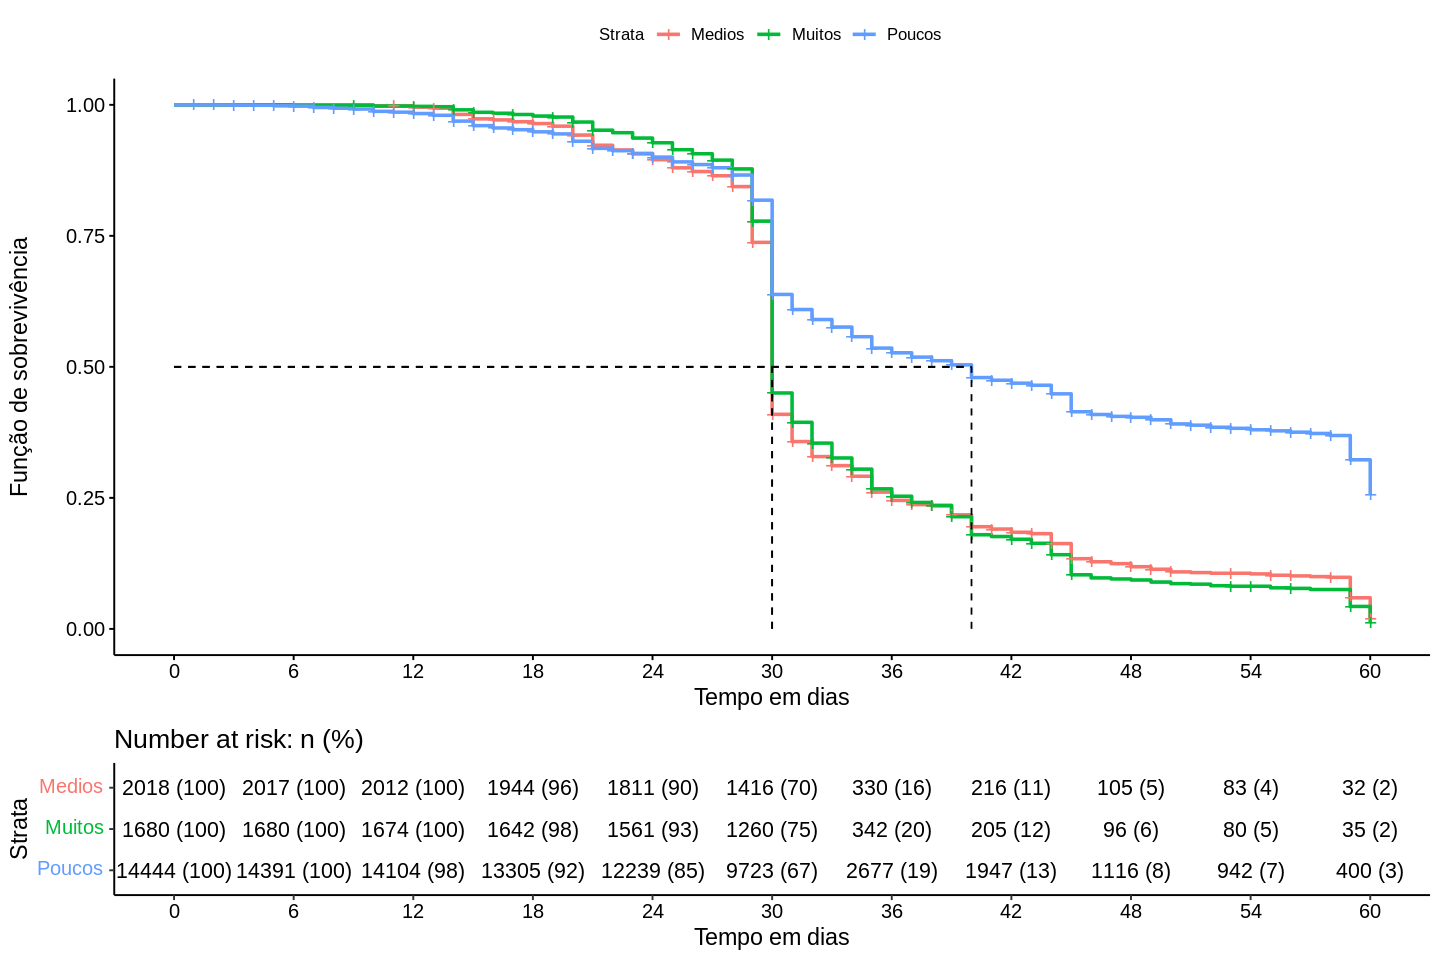

In [ ]:
# Grafico de cada curva estimada:
options(repr.plot.width = 12, repr.plot.height = 8)

ggsurvplot(mKM_shares,  # objeto do survfit
           data = data,
           #pval = TRUE, # mostra o p-value do teste log-rank.
           xlab = "Tempo em dias",
           ylab="Função de sobrevivência",
           break.time.by = 6, #eixo X em intervalos de comprimento 6.
           risk.table = "abs_pct", # indivíduos em risco.
           surv.median.line = "hv", # sobrevivência mediana.
           legend.labs = levels(as.factor(data$qtd_shares))
)

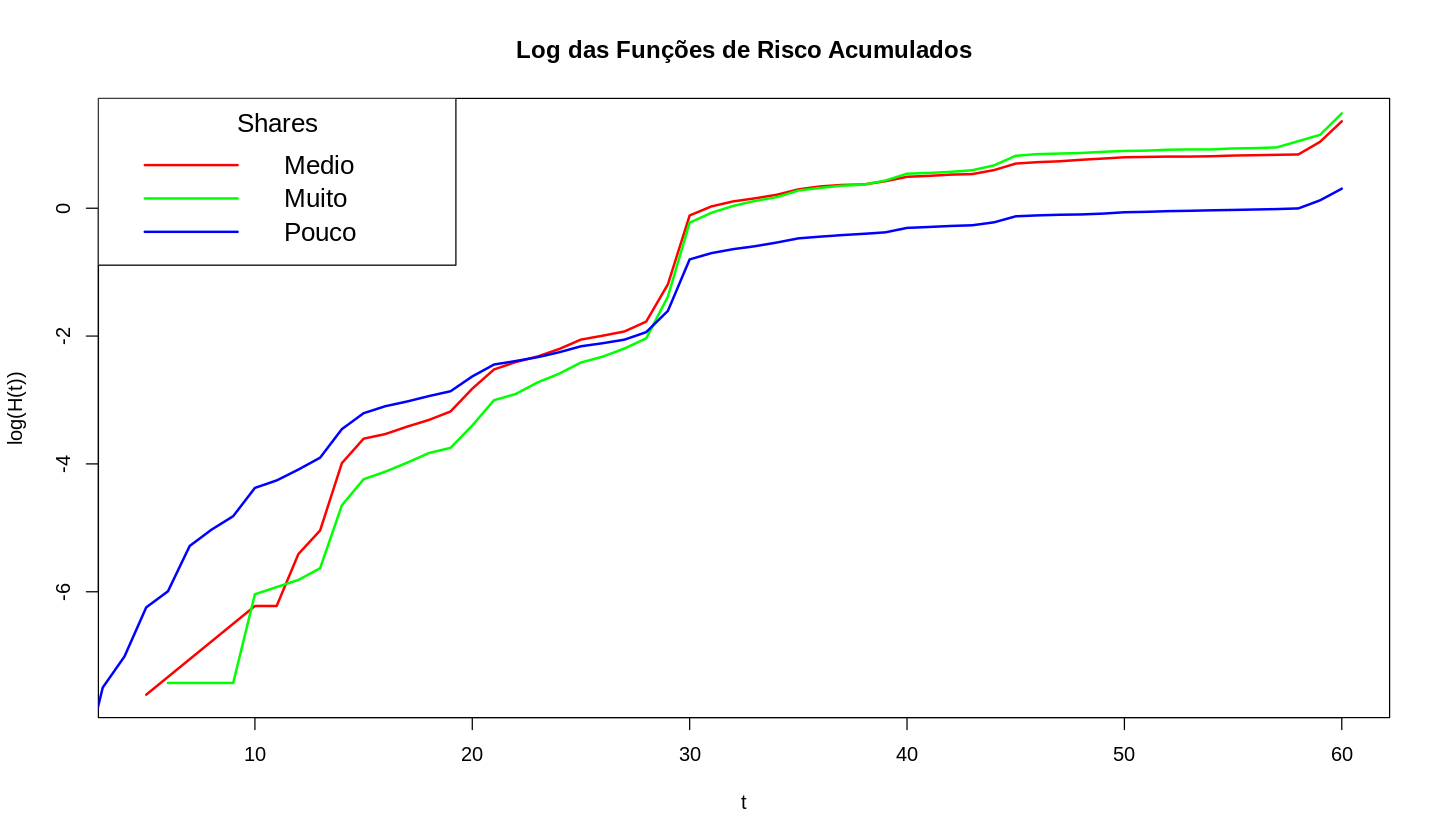

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 7)

plot(mKM_shares[1]$time, log(-log(mKM_shares[1]$surv)),
     xlab='t', ylab='log(H(t))', col='red', type='l',
     lwd=2, main='Log das Funções de Risco Acumulados')
lines(mKM_shares[2]$time, log(-log(mKM_shares[2]$surv)),
      col='green', lwd=2)
lines(mKM_shares[3]$time, log(-log(mKM_shares[3]$surv)),
      col='blue', lwd=2)

legend('topleft', c('Medio', 'Muito', 'Pouco'), title='Shares',
       col = c('red', 'green', 'blue'), lwd=2, cex=1.3)

In [ ]:
# Apenas o teste log-rank para 3 categorias
survdiff(Surv(duration, censoring)~qtd_shares, data=data, rho=3)

Call:
survdiff(formula = Surv(duration, censoring) ~ qtd_shares, data = data, 
    rho = 3)

                      N Observed Expected (O-E)^2/E (O-E)^2/V
qtd_shares=Medios  2018      761      521     110.7     209.8
qtd_shares=Muitos  1680      599      457      44.1      83.3
qtd_shares=Poucos 14444     3201     3582      40.7     320.7

 Chisq= 329  on 2 degrees of freedom, p= <2e-16 

In [ ]:
# Teste log-rank ponderado dois a dois:
pairwise_survdiff(Surv(duration, censoring)~qtd_shares,
                  data, p.adjust.method = 'bonferroni')


	Pairwise comparisons using Log-Rank test 

data:  data and qtd_shares 

       Medios Muitos
Muitos 1      -     
Poucos <2e-16 <2e-16

P value adjustment method: bonferroni 

## Comparação entre os intervalos e a conexão no facebook

In [ ]:
mKM_s_f <- survfit(Surv(duration, censoring)~facebook+qtd_shares, data)
print(mKM_s_f, print.rmean=TRUE)

Call: survfit(formula = Surv(duration, censoring) ~ facebook + qtd_shares, 
    data = data)

                                   n events rmean* se(rmean) median 0.95LCL
facebook=No, qtd_shares=Medios   557    422   34.5     0.540     30      30
facebook=No, qtd_shares=Muitos   551    471   34.5     0.455     30      30
facebook=No, qtd_shares=Poucos  4744   1944   42.5     0.293     40      39
facebook=Yes, qtd_shares=Medios 1461   1165   33.8     0.313     30      30
facebook=Yes, qtd_shares=Muitos 1129    955   33.9     0.308     30      30
facebook=Yes, qtd_shares=Poucos 9700   4081   42.1     0.205     39      38
                                0.95UCL
facebook=No, qtd_shares=Medios       30
facebook=No, qtd_shares=Muitos       31
facebook=No, qtd_shares=Poucos       41
facebook=Yes, qtd_shares=Medios      30
facebook=Yes, qtd_shares=Muitos      30
facebook=Yes, qtd_shares=Poucos      40
    * restricted mean with upper limit =  60 


Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”
Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


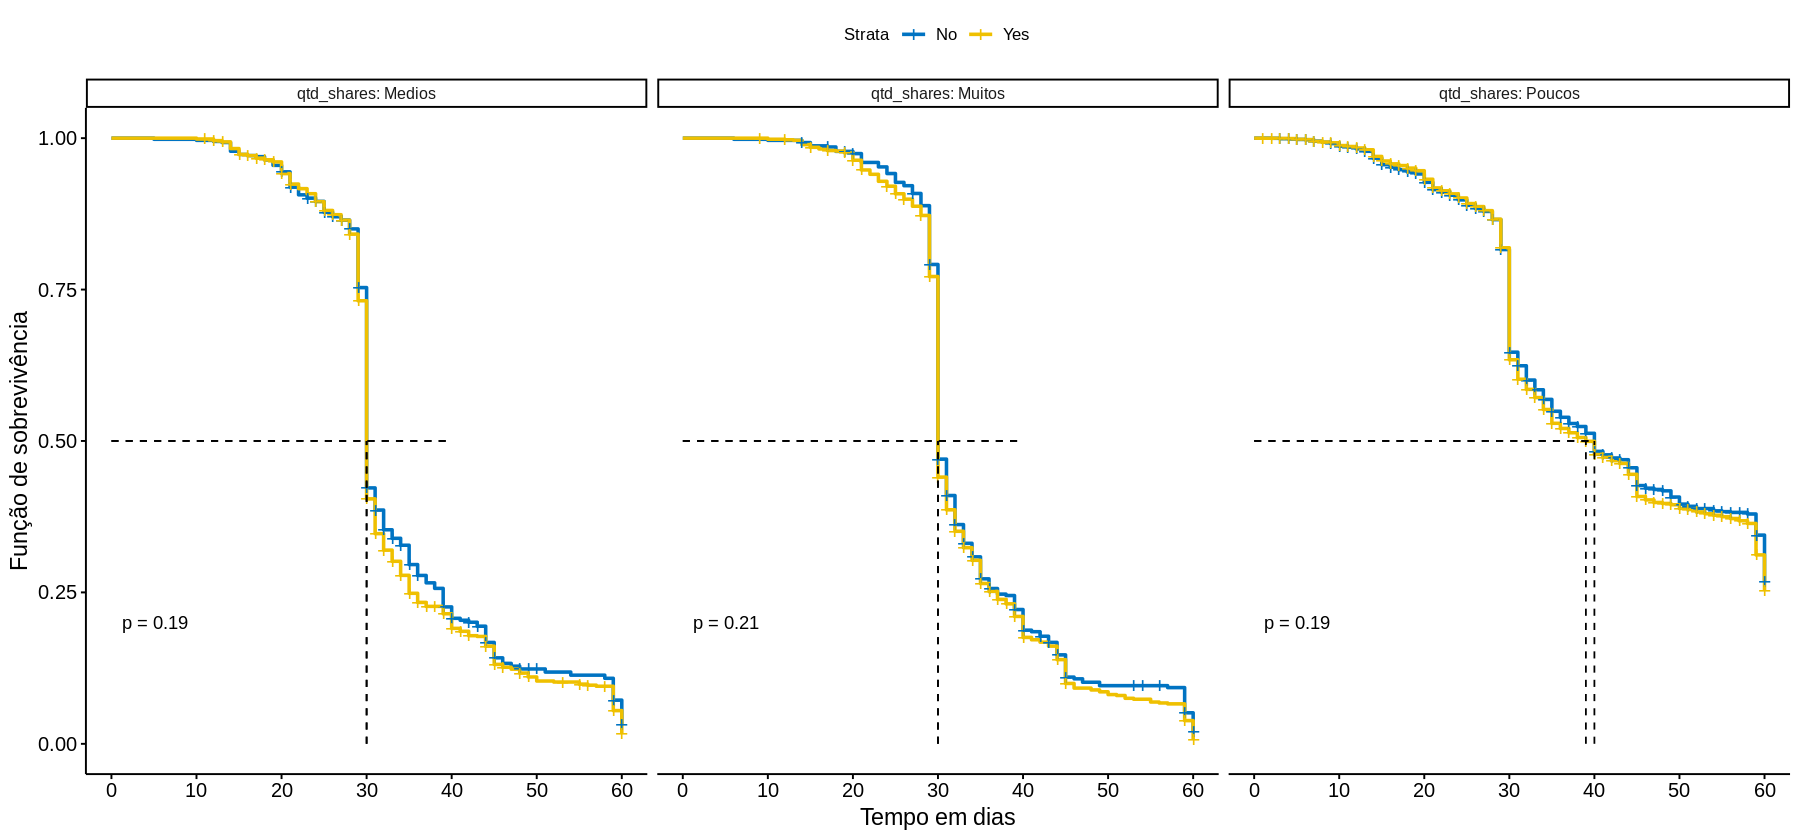

In [ ]:
# Influencia do facebook, dada a qtd de shares
options(repr.plot.width = 15, repr.plot.height = 7)

ggsurvplot_facet(mKM_s_f,
                 data,
                 facet.by = "qtd_shares",
                 palette="jco",
                 xlab = "Tempo em dias",
                 ylab="Função de sobrevivência",
                 break.time.by = 10, 
                 surv.median.line="hv",
                 pval = TRUE
)

In [ ]:
survdiff(Surv(duration, censoring)~facebook+qtd_shares, data, rho=-1)

Call:
survdiff(formula = Surv(duration, censoring) ~ facebook + qtd_shares, 
    data = data, rho = -1)

                                   N Observed Expected (O-E)^2/E (O-E)^2/V
facebook=No, qtd_shares=Medios   557      636      396       144       101
facebook=No, qtd_shares=Muitos   551      775      455       225       150
facebook=No, qtd_shares=Poucos  4744     2857     3603       154       132
facebook=Yes, qtd_shares=Medios 1461     1757     1024       525       386
facebook=Yes, qtd_shares=Muitos 1129     1540      858       542       389
facebook=Yes, qtd_shares=Poucos 9700     5977     7206       210       285

 Chisq= 1201  on 5 degrees of freedom, p= <2e-16 

In [ ]:
pairwise_survdiff(Surv(duration, censoring)~facebook+qtd_shares,
                  data, p.adjust.method = 'bonferroni')


	Pairwise comparisons using Log-Rank test 

data:  data and facebook + qtd_shares 

                                facebook=No, qtd_shares=Medios
facebook=No, qtd_shares=Muitos  1                             
facebook=No, qtd_shares=Poucos  <2e-16                        
facebook=Yes, qtd_shares=Medios 1                             
facebook=Yes, qtd_shares=Muitos 1                             
facebook=Yes, qtd_shares=Poucos <2e-16                        
                                facebook=No, qtd_shares=Muitos
facebook=No, qtd_shares=Muitos  -                             
facebook=No, qtd_shares=Poucos  <2e-16                        
facebook=Yes, qtd_shares=Medios 1                             
facebook=Yes, qtd_shares=Muitos 1                             
facebook=Yes, qtd_shares=Poucos <2e-16                        
                                facebook=No, qtd_shares=Poucos
facebook=No, qtd_shares=Muitos  -                             
facebook=No, qtd_shares=Poucos  -

Resumo disso ai, só quando há poucos compartilhamentos que existe diferença.

# Modelo para Friends

## Comparação direta de friends

In [ ]:
# modelo para a quantidade de amigos:
mKM_friends <- survfit(Surv(duration, censoring)~qtd_friends, data)
print(mKM_friends, print.rmean=TRUE)

Call: survfit(formula = Surv(duration, censoring) ~ qtd_friends, data = data)

                            n events rmean* se(rmean) median 0.95LCL 0.95UCL
qtd_friends=Desconhecido 5852   2837   40.3     0.245     35      34      35
qtd_friends=Medios       4831   1943   43.0     0.288     40      39      43
qtd_friends=Muitos       6749   4092   36.8     0.202     31      30      31
qtd_friends=Poucos        710    166   48.9     0.774     60      56      NA
    * restricted mean with upper limit =  60 


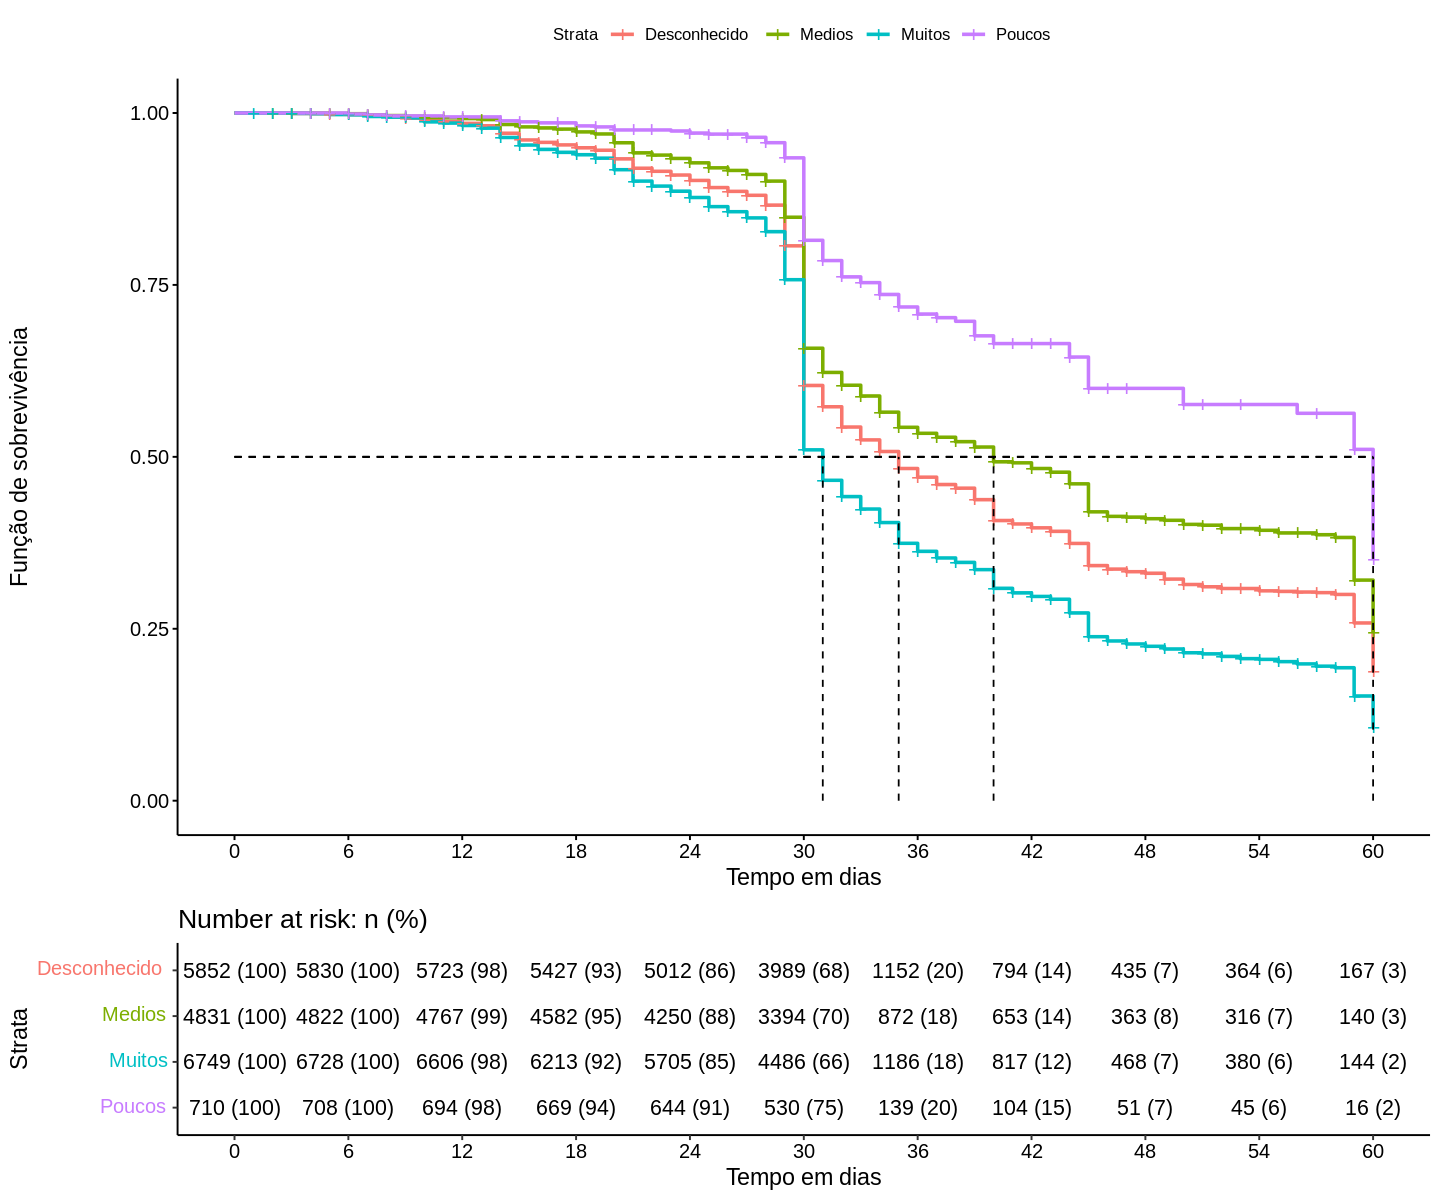

In [ ]:
# grafico comparando as curvas da quantidade de amigos:
options(repr.plot.width = 12, repr.plot.height = 10)

ggsurvplot(mKM_friends,  # objeto do survfit
           data = data,
           xlab = "Tempo em dias",
           ylab="Função de sobrevivência",
           break.time.by = 6, #eixo X em intervalos de comprimento 6.
           risk.table = "abs_pct", # indivíduos em risco.
           surv.median.line = "hv", # sobrevivência mediana.
           legend.labs = levels(as.factor(data$qtd_friends))
)

In [ ]:
# teste logrank entre todas as curvas:
survdiff(Surv(duration , censoring)~qtd_friends, data)

Call:
survdiff(formula = Surv(duration, censoring) ~ qtd_friends, data = data)

                            N Observed Expected (O-E)^2/E (O-E)^2/V
qtd_friends=Desconhecido 5852     2837     2946      4.03      6.83
qtd_friends=Medios       4831     1943     2456    107.25    168.49
qtd_friends=Muitos       6749     4092     3257    214.35    383.04
qtd_friends=Poucos        710      166      379    119.94    143.33

 Chisq= 510  on 3 degrees of freedom, p= <2e-16 

In [ ]:
# teste logrank dois a dois:
pairwise_survdiff(Surv(duration , censoring)~qtd_friends,
                  data, p.adjust.method = 'bonferroni')


	Pairwise comparisons using Log-Rank test 

data:  data and qtd_friends 

       Desconhecido Medios  Muitos 
Medios 6.4e-12      -       -      
Muitos < 2e-16      < 2e-16 -      
Poucos < 2e-16      2.1e-14 < 2e-16

P value adjustment method: bonferroni 

## Comparação entre os intervalos e o facebook

In [ ]:
mKM_f_f <- survfit(Surv(duration , censoring)~facebook+qtd_friends, data)
print(mKM_f_f, print.rmean=TRUE)

Call: survfit(formula = Surv(duration, censoring) ~ facebook + qtd_friends, 
    data = data)

                                          n events rmean* se(rmean) median
facebook=No, qtd_friends=Desconhecido  5852   2837   40.3     0.245     35
facebook=Yes, qtd_friends=Medios       4831   1943   43.0     0.288     40
facebook=Yes, qtd_friends=Muitos       6749   4092   36.8     0.202     31
facebook=Yes, qtd_friends=Poucos        710    166   48.9     0.774     60
                                       0.95LCL 0.95UCL
facebook=No, qtd_friends=Desconhecido       34      35
facebook=Yes, qtd_friends=Medios            39      43
facebook=Yes, qtd_friends=Muitos            30      31
facebook=Yes, qtd_friends=Poucos            56      NA
    * restricted mean with upper limit =  60 


Warning message in .f(.x[[i]], .y[[i]], ...):
“There are no survival curves to be compared. 
 This is a null model.”


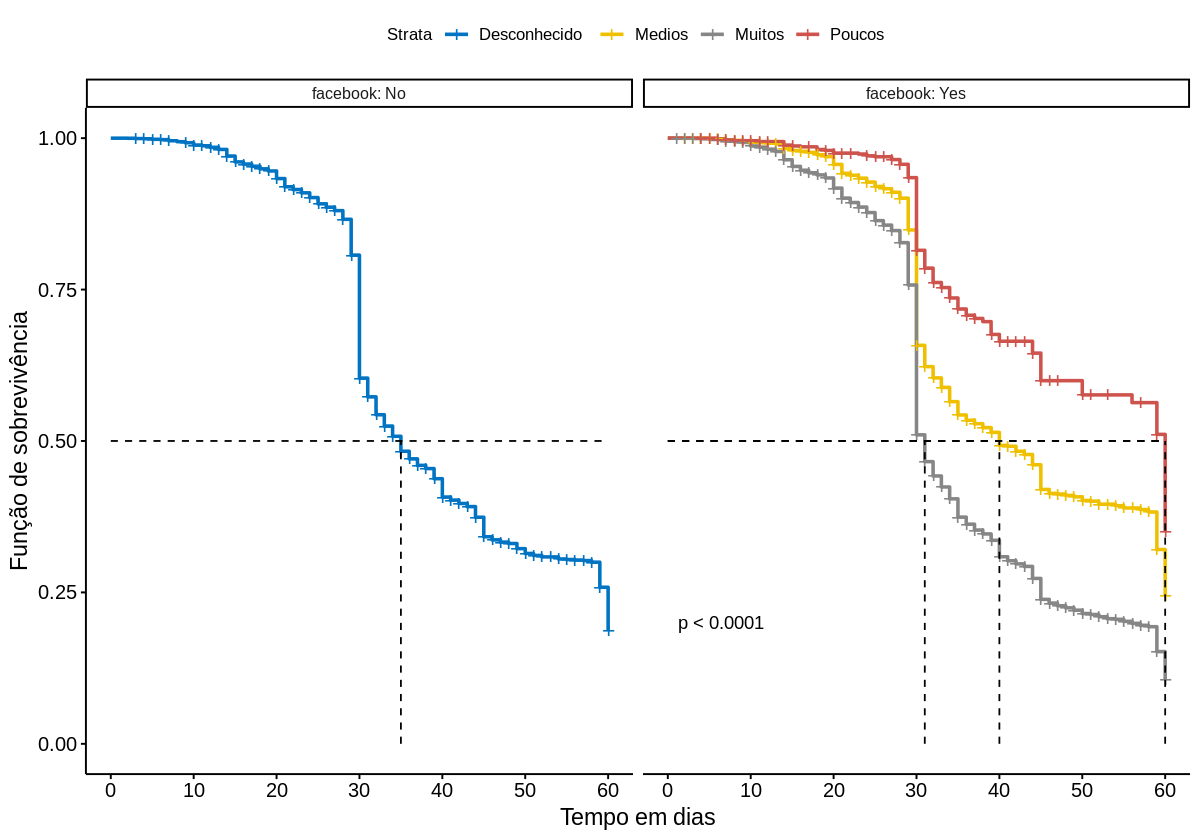

In [ ]:
# Influencia do facebook, dada a qtd de friends
options(repr.plot.width = 10, repr.plot.height = 7)

ggsurvplot_facet(mKM_f_f,
                 data,
                 facet.by = "facebook",
                 palette="jco",
                 xlab = "Tempo em dias",
                 ylab="Função de sobrevivência",
                 break.time.by = 10, 
                 surv.median.line="hv",
                 pval = TRUE
)

In [ ]:
survdiff(Surv(duration , censoring)~facebook+qtd_friends, data)

Call:
survdiff(formula = Surv(duration, censoring) ~ facebook + qtd_friends, 
    data = data)

                                          N Observed Expected (O-E)^2/E
facebook=No, qtd_friends=Desconhecido  5852     2837     2946      4.03
facebook=Yes, qtd_friends=Medios       4831     1943     2456    107.25
facebook=Yes, qtd_friends=Muitos       6749     4092     3257    214.35
facebook=Yes, qtd_friends=Poucos        710      166      379    119.94
                                       (O-E)^2/V
facebook=No, qtd_friends=Desconhecido       6.83
facebook=Yes, qtd_friends=Medios          168.49
facebook=Yes, qtd_friends=Muitos          383.04
facebook=Yes, qtd_friends=Poucos          143.33

 Chisq= 510  on 3 degrees of freedom, p= <2e-16 

In [ ]:
pairwise_survdiff(Surv(duration , censoring)~facebook+qtd_friends,
                  data, p.adjust.method = 'bonferroni')


	Pairwise comparisons using Log-Rank test 

data:  data and facebook + qtd_friends 

                                       facebook=No, qtd_friends=Desconhecido
facebook=Yes, qtd_friends=Medios       6.4e-12                              
facebook=Yes, qtd_friends=Muitos       < 2e-16                              
facebook=Yes, qtd_friends=Poucos       < 2e-16                              
                                       facebook=Yes, qtd_friends=Medios      
facebook=Yes, qtd_friends=Medios       -                                     
facebook=Yes, qtd_friends=Muitos       < 2e-16                               
facebook=Yes, qtd_friends=Poucos       2.1e-14                               
                                       facebook=Yes, qtd_friends=Muitos      
facebook=Yes, qtd_friends=Medios       -                                     
facebook=Yes, qtd_friends=Muitos       -                                     
facebook=Yes, qtd_friends=Poucos       < 2e-16              

## Comparação entre friends e shares

In [ ]:
mKM_f_s <- survfit(Surv(duration, censoring)~qtd_shares+qtd_friends, data)
print(mKM_f_s, print.rmean=TRUE)

Call: survfit(formula = Surv(duration, censoring) ~ qtd_shares + qtd_friends, 
    data = data)

                                               n events rmean* se(rmean) median
qtd_shares=Medios, qtd_friends=Desconhecido  557    422   34.5     0.540   30.0
qtd_shares=Medios, qtd_friends=Medios        362    264   35.5     0.702   30.0
qtd_shares=Medios, qtd_friends=Muitos       1077    889   33.2     0.347   30.0
qtd_shares=Medios, qtd_friends=Poucos         22     12   42.7     3.373   34.5
qtd_shares=Muitos, qtd_friends=Desconhecido  551    471   34.5     0.455   30.0
qtd_shares=Muitos, qtd_friends=Medios        246    190   35.8     0.699   31.0
qtd_shares=Muitos, qtd_friends=Muitos        865    754   33.3     0.342   30.0
qtd_shares=Muitos, qtd_friends=Poucos         18     11   37.7     3.568   31.0
qtd_shares=Poucos, qtd_friends=Desconhecido 4744   1944   42.5     0.293   40.0
qtd_shares=Poucos, qtd_friends=Medios       4223   1489   44.7     0.318   45.0
qtd_shares=Poucos, qtd_

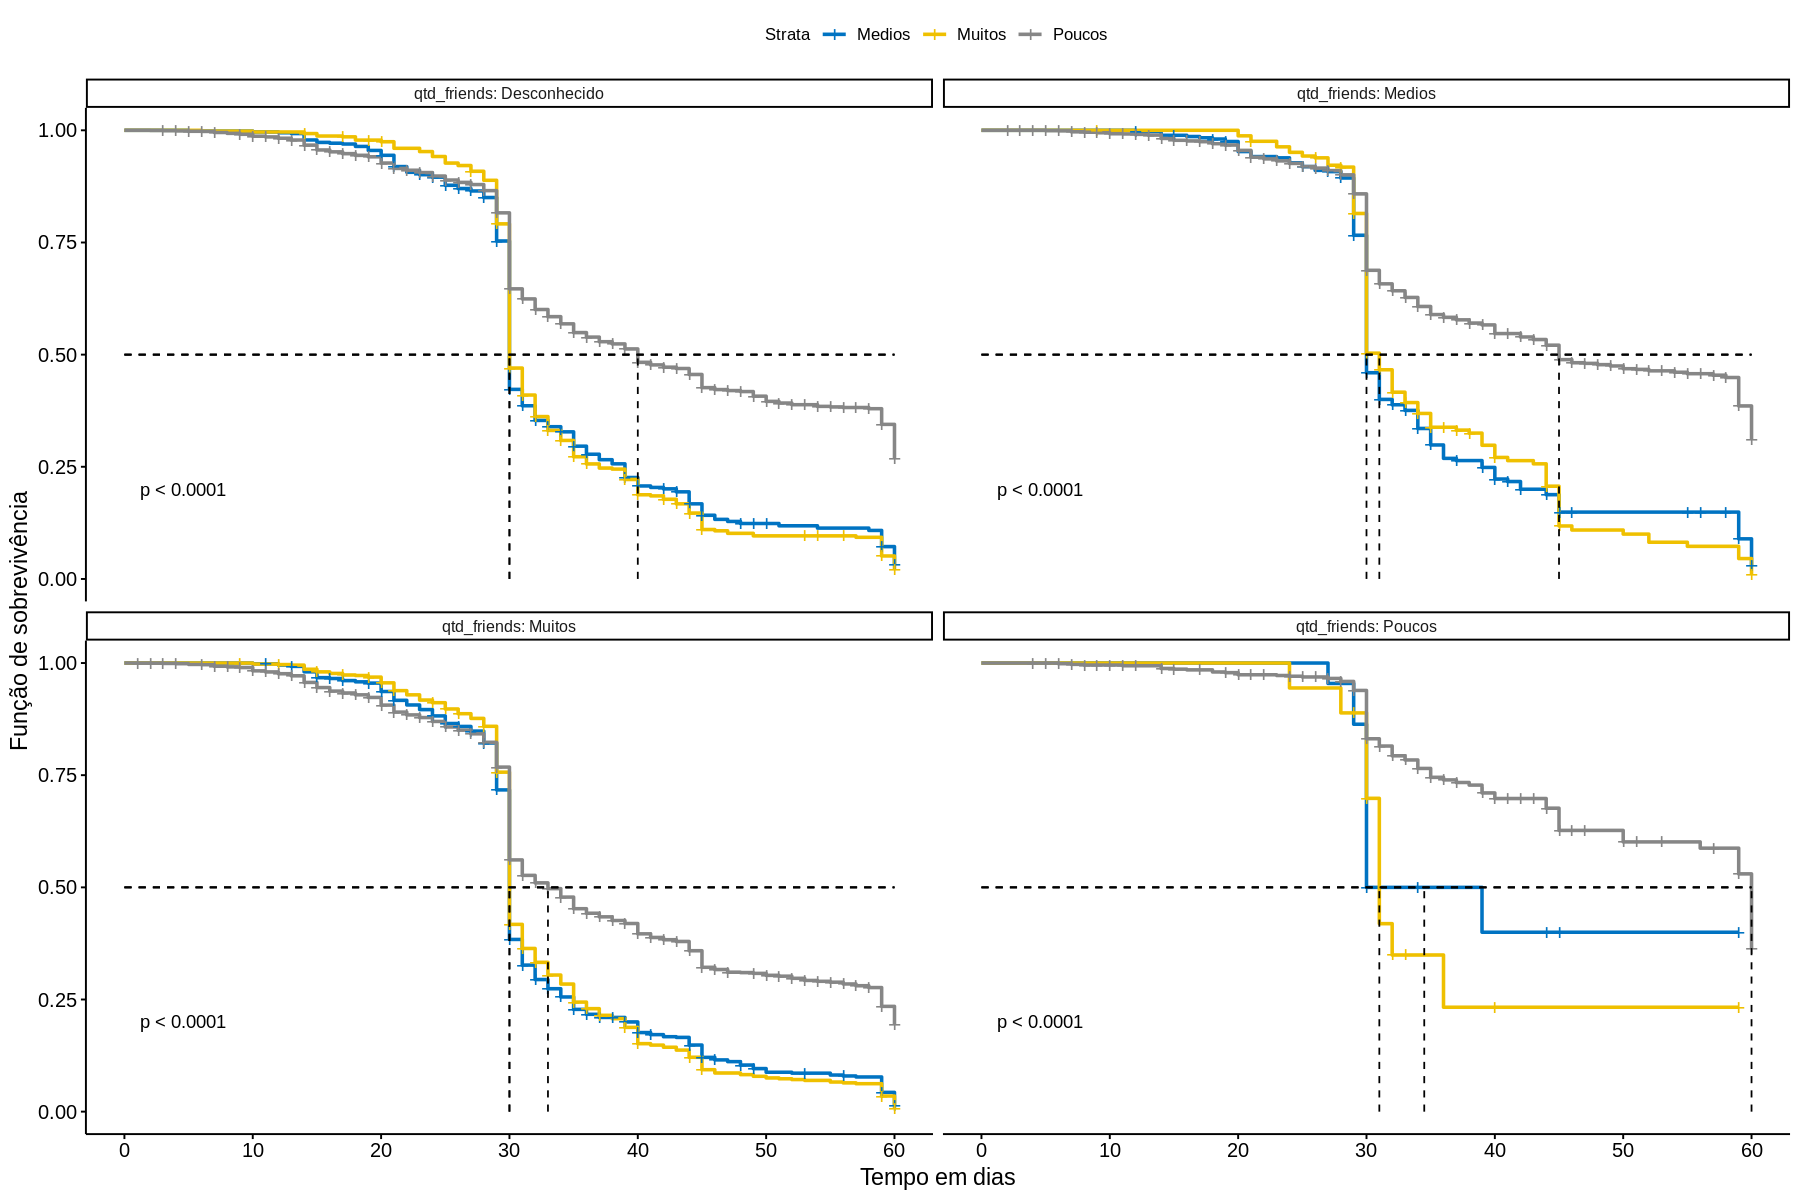

In [ ]:
# Influencia dos compartilhamentos, dada a qtd de friends
options(repr.plot.width = 15, repr.plot.height =11)

ggsurvplot_facet(mKM_f_s, data,
                 facet.by = "qtd_friends",
                 palette="jco",
                 xlab = "Tempo em dias",
                 ylab="Função de sobrevivência",
                 break.time.by = 10, 
                 surv.median.line="hv",
                 pval = TRUE
)

In [ ]:
survdiff(Surv(duration, censoring)~qtd_shares+qtd_friends, data)

Call:
survdiff(formula = Surv(duration, censoring) ~ qtd_shares + qtd_friends, 
    data = data)

                                               N Observed Expected (O-E)^2/E
qtd_shares=Medios, qtd_friends=Desconhecido  557      422   276.06   77.1564
qtd_shares=Medios, qtd_friends=Medios        362      264   184.95   33.7902
qtd_shares=Medios, qtd_friends=Muitos       1077      889   517.83  266.0400
qtd_shares=Medios, qtd_friends=Poucos         22       12    12.61    0.0294
qtd_shares=Muitos, qtd_friends=Desconhecido  551      471   305.90   89.1075
qtd_shares=Muitos, qtd_friends=Medios        246      190   136.46   21.0055
qtd_shares=Muitos, qtd_friends=Muitos        865      754   445.95  212.7924
qtd_shares=Muitos, qtd_friends=Poucos         18       11     9.56    0.2177
qtd_shares=Poucos, qtd_friends=Desconhecido 4744     1944  2363.97   74.6112
qtd_shares=Poucos, qtd_friends=Medios       4223     1489  2134.86  195.3919
qtd_shares=Poucos, qtd_friends=Muitos       4807     24

In [ ]:
pairwise_survdiff(Surv(duration, censoring)~qtd_shares+qtd_friends,
                  data, p.adjust.method = 'bonferroni')


	Pairwise comparisons using Log-Rank test 

data:  data and qtd_shares + qtd_friends 

                                            qtd_shares=Medios, qtd_friends=Desconhecido
qtd_shares=Medios, qtd_friends=Medios       1.00000                                    
qtd_shares=Medios, qtd_friends=Muitos       1.00000                                    
qtd_shares=Medios, qtd_friends=Poucos       1.00000                                    
qtd_shares=Muitos, qtd_friends=Desconhecido 1.00000                                    
qtd_shares=Muitos, qtd_friends=Medios       1.00000                                    
qtd_shares=Muitos, qtd_friends=Muitos       1.00000                                    
qtd_shares=Muitos, qtd_friends=Poucos       1.00000                                    
qtd_shares=Poucos, qtd_friends=Desconhecido < 2e-16                                    
qtd_shares=Poucos, qtd_friends=Medios       < 2e-16                                    
qtd_shares=Poucos, qtd_friends=M